In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns("Measurement")
for col in columns:
    print(col["name"],col["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
df1 = pd.read_sql("select * from Measurement",session.bind)
df1

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [12]:
columns = inspector.get_columns("Station")
for col in columns:
    print(col["name"],col["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
df2 = pd.read_sql("select * from Station",session.bind)
df2

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [15]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days =365)
year_ago

datetime.date(2016, 8, 23)

In [16]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date,Measurement.prcp).filter(func.strftime('%Y-%m-%d',Measurement.date) >= year_ago).all()
precip_data

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data,columns=["date","prcp"])
precip_df.set_index("date",inplace = True)
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [18]:
# Sort the dataframe by date
precip_df = precip_df.sort_values(["date"],ascending=True)
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


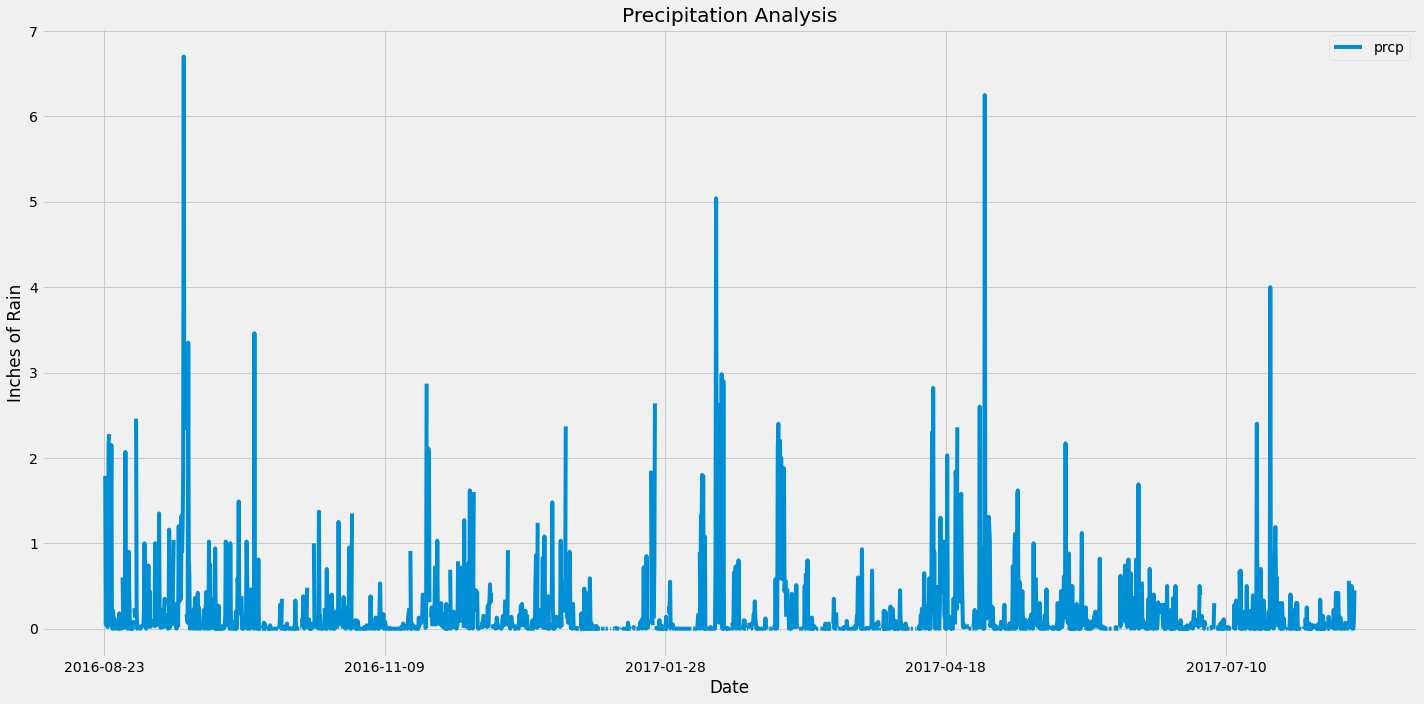

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Precipitation Analysis", figsize=(20,10))
plt.ylabel("Inches of Rain")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = precip_df.describe()
summary_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station analysis 

In [21]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
stations

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station ='USC00519281').all()
active_station_temp

[(54.0, 85.0, 71.66378066378067)]

In [24]:
# Choose the station with the highest number of temperature observations.
station_temp_ob = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
station_temp_ob
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_ob = session.query(Measurement.tobs,Measurement.date).filter(Measurement.station =="USC00519281").filter(func.strftime('%Y-%m-%d',Measurement.date) >= year_ago).all()
temp_ob


[(77.0, '2016-08-23'),
 (77.0, '2016-08-24'),
 (80.0, '2016-08-25'),
 (80.0, '2016-08-26'),
 (75.0, '2016-08-27'),
 (73.0, '2016-08-28'),
 (78.0, '2016-08-29'),
 (77.0, '2016-08-30'),
 (78.0, '2016-08-31'),
 (80.0, '2016-09-01'),
 (80.0, '2016-09-02'),
 (78.0, '2016-09-03'),
 (78.0, '2016-09-04'),
 (78.0, '2016-09-05'),
 (73.0, '2016-09-06'),
 (74.0, '2016-09-07'),
 (80.0, '2016-09-08'),
 (79.0, '2016-09-09'),
 (77.0, '2016-09-10'),
 (80.0, '2016-09-11'),
 (76.0, '2016-09-12'),
 (79.0, '2016-09-13'),
 (75.0, '2016-09-14'),
 (79.0, '2016-09-15'),
 (78.0, '2016-09-16'),
 (79.0, '2016-09-17'),
 (78.0, '2016-09-18'),
 (78.0, '2016-09-19'),
 (76.0, '2016-09-20'),
 (74.0, '2016-09-21'),
 (77.0, '2016-09-22'),
 (78.0, '2016-09-23'),
 (79.0, '2016-09-24'),
 (79.0, '2016-09-25'),
 (77.0, '2016-09-26'),
 (80.0, '2016-09-27'),
 (78.0, '2016-09-28'),
 (78.0, '2016-09-29'),
 (78.0, '2016-09-30'),
 (77.0, '2016-10-01'),
 (79.0, '2016-10-02'),
 (79.0, '2016-10-03'),
 (79.0, '2016-10-04'),
 (79.0, '20

In [25]:
temp_df = pd.DataFrame(temp_ob,columns=["tobs","date"])
temp_df.set_index("date",inplace=True)
temp_df.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


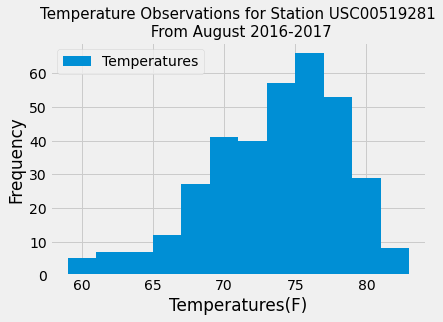

In [26]:
plt.hist(temp_df["tobs"], bins=12, label = "Temperatures")
plt.xlabel("Temperatures(F)")
plt.ylabel("Frequency")
plt.title("Temperature Observations for Station USC00519281\n From August 2016-2017",fontsize=15)
plt.legend(loc='best')
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps("2017-07-03","2017-07-15")
trip
trip_df = pd.DataFrame(trip, columns=["TMIN","TMAX","TAVG"])
trip_df

,TMIN,TMAX,TAVG
0,69.0,78.240964,87.0


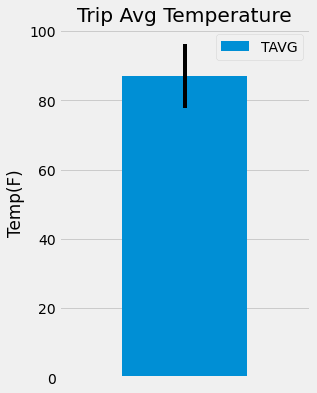

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y="TAVG",title= "Trip Avg Temperature", yerr= (trip_df["TMAX"]- trip_df["TMIN"]),figsize=(4,6))
plt.ylabel("Temp(F)")
plt.xticks([])
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
stmt = session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp))\
.filter(Measurement.station == Station.station).filter(func.strftime("%Y-%m-%d",Measurement.date)>="2017-07-03")\
.filter(func.strftime("%Y-%m-%d",Measurement.date)<="2017-07-15").group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).statement

print("Total precipitation amount per weather station for dates between 2017-07-03 and 2017-07-15")
prcp_per_station = pd.read_sql_query(stmt,session.bind)
prcp_per_station = prcp_per_station.rename(columns={"sum_1":"total prcp"})
prcp_per_station 


Total precipitation amount per weather station for dates between 2017-07-03 and 2017-07-15


,station,name,latitude,longitude,elevation,total prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.27
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.41
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.72
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.39
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.17
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.13
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals =[]
# Set the start and end date of the trip
start_date = "2017-07-03"
end_date = "2017-07-15"
# Use the start and end date to create a range of dates
range_dates = pd.date_range(start_date,end_date)
# Stip off the year and save a list of %m-%d strings
month_day = range_dates.strftime("%m-%d")
# Loop through the list of %m-%d strings and calculate the normals for each date
for row in month_day:
    normals.append(*daily_normals(row))
normals

[(68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0)]

In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals, columns=["TMIN","TAVG","TMAX"])
normal_df
normal_df["date"] = month_day
normal_df.set_index("date",inplace=True)
normal_df

,TMIN,TAVG,TMAX
date,,,
07-03,68.0,75.320755,87.0
07-04,70.0,76.571429,81.0
07-05,66.0,75.000000,81.0
07-06,69.0,75.000000,81.0
07-07,69.0,74.910714,82.0
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0
07-10,68.0,75.620690,82.0
07-11,70.0,75.789474,81.0


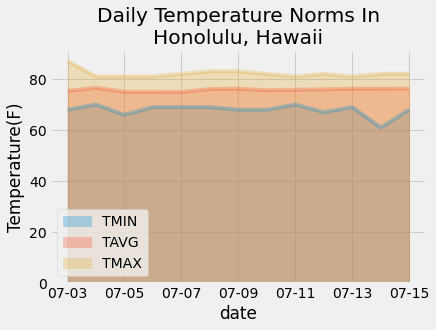

In [34]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(stacked=False, alpha = 0.3)
plt.title("Daily Temperature Norms In\nHonolulu, Hawaii")
plt.ylabel("Temperature(F)")
plt.show()


Temperature Analysis 1

In [35]:
#find average june temperature 
june_temp = session.query(Measurement.station,Measurement.tobs,Measurement.date).filter(func.strftime("%m",Measurement.date)=="06").statement
june_df = pd.read_sql_query(june_temp,session.bind)
june_df
avg_june_temp = june_df["tobs"].mean()
avg_june_temp

74.94411764705882

In [36]:
# find average december temperature 
dec_temp = session.query(Measurement.station,Measurement.tobs,Measurement.date).filter(func.strftime("%m",Measurement.date)=="12").statement
dec_df = pd.read_sql_query(dec_temp,session.bind)
avg_dec_temp = dec_df["tobs"].mean()
avg_dec_temp


71.04152933421226

In [37]:
from scipy import stats

In [38]:
stats.ttest_ind(june_df["tobs"],dec_df["tobs"])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

An unpaired t-test was used to determine whether the difference in means between the average temperature in June and December across all stations between the years 2010-2017 were statistically significant. The p-value is extremely low so we can reject the null hypothesis and conclude that the difference between the average temperature in June and December is statiscally significant.